In [1]:
from pathlib import Path
path = Path('/home/ubuntu/code/looking-glass-')

## imports / setup

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import re
from PIL import Image
import imageio
import gc


from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

import torch
import torch.nn.functional as F
from torchvision import datasets
from torchvision import transforms

import utils
from transformer_net import TransformerNet
from vgg import Vgg16
from RAdam import RAdam



In [4]:
from functools import reduce

In [5]:
device = torch.device(0) if torch.cuda.is_available() else torch.device('cpu')

In [6]:
def resize_img(img, size=256):
    MAXWIDTH = size
    h,w= img.size 
    ratio = MAXWIDTH/w
    return img.resize((int(h*ratio), int(w*ratio)), Image.ANTIALIAS)

def crop_img(img):
    h,w = img.size
    print(h,w, 255-h, 255-w)
    return img.crop((0, 30, w, h-30))
 
def scale_img(img, size=256):
    return img.resize((size, size), Image.ANTIALIAS)

def content_transform(img):
    np.array(x_img)
    
# content_transform = transforms.Compose([
#     transforms.ToTensor(), 
#     transforms.Lambda(lambda x: x.mul(255))
# ])



def content_transform(x):
    img = torch.from_numpy(np.array(x).transpose((2, 0, 1)))
    return img.float()

def convert_to_image(data):
    data = data.detach()
    img = data.clone()
    img = img.clamp(0, 255).numpy()
    img = img.transpose(1, 2, 0).astype("uint8")
    return Image.fromarray(img)

def pre_process_image(PIL_IMG, size=256):
    img = resize_img(PIL_IMG, size)
    img = scale_img(img, size)
    x = content_transform(img)
    x = x.unsqueeze(0).to(device)
    return x

In [109]:
x_img = Image.open(path/'photos/trump.jpeg')
# y_img = Image.open(path/'photos/goldie.jpg') 
vincent_img = Image.open(path/'photos/vincent.jpg') 

In [110]:
def get_data(yc_img, y_img, size=256):
    yc = pre_process_image(yc_img, size)
    y = pre_process_image(y_img, size)
    return yc, y

In [111]:
yc, y = get_data(x_img, vincent_img, 256)
yc.shape, y.shape

(torch.Size([1, 3, 256, 256]), torch.Size([1, 3, 256, 256]))

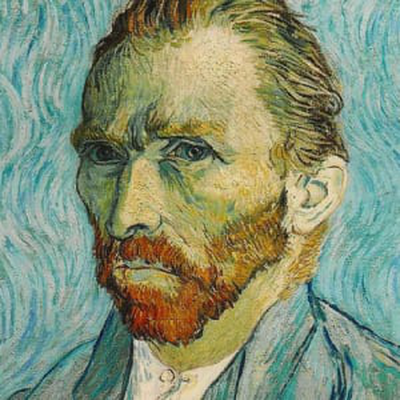

In [149]:
convert_to_image(y.cpu()[0])

In [113]:
vgg = Vgg16().to(device)
# style_model = TransformerNet().to(device)

In [114]:
yc_feats = vgg(yc)
y_hat_feats = vgg(yc)
y_feats = vgg(y)

In [115]:
yc_feats[0].shape

torch.Size([1, 64, 256, 256])


# feature loss function

$
\ell_{feat}^{\phi , j}(\hat{y}, y) = \frac{1}{C_{j}H_{j}W_{j} } \left\lVert \phi_{j}(\hat{y}) - \phi_{j}(y) \right\rVert
$

In [116]:
def layer_feat_loss(yj_hat, yj):
    normalise_by = 1 / yj_hat.numel()
    pairwise_dist = yj_hat - yj
    t_sum = torch.sum(pairwise_dist**2)
    t_sqrt = torch.sqrt(t_sum)
    return normalise_by * t_sqrt

In [117]:
layer_feat_loss(y_hat_feats[0], y_feats[0])

tensor(0.0454, device='cuda:0')

In [118]:
# check that the same tensor has 0 distance
fn = layer_feat_loss
assert(torch.eq(fn(y_feats[0], y_feats[0]),torch.tensor([0.]).to(device)).item())

In [119]:
# def gram_matrix(x):
x = y_feats[1]

In [120]:
def gram_matrix(x):
    bs,c,h,w = x.shape
    
    # reshape features to C x H*W
    features = x.view(bs*c, h*w)
    
    # calculate gram matrix by mat mult
    gram = torch.matmul(features, features.t())
    # output is then shape C x C
    # gram.shape
    return gram.div(c*h*w)

In [121]:
gram_matrix(y_feats[1]).shape

torch.Size([128, 128])

# Style reconstruction loss



In [122]:
# per layer style reconstruction loss
def style_recon_loss(y_hat, y):
    gy_hat, gy = gram_matrix(y_hat), gram_matrix(y)
    dist = gy_hat - gy 
    dist_sq = dist**2
    t_sum = torch.sum(dist_sq)
    t_sqrt = torch.sqrt(t_sum)
    return t_sqrt * 1/gy_hat.numel()

In [123]:
style_recon_loss(y_hat_feats[1],y_feats[1])

tensor(1.2711, device='cuda:0')

In [124]:
# sum of loss at each layer
def multi_layer_loss(y_hat, y, fn):
    l = y_hat.__len__()
    list_of_losses = torch.zeros(l).to(device)
    for i in range(0,l-1):
        list_of_losses[i] = fn(y_hat[i], y[i])
    return torch.sum(list_of_losses)

def style_loss_layers(y_hat, y): 
    return multi_layer_loss(y_hat, y, style_recon_loss)

def feature_loss_layers(y_hat, y): 
    l = y_hat.__len__()
    list_of_losses = torch.zeros(l).to(device)
    for i in range(0,l-1):
        list_of_losses[i] = layer_feat_loss(y_hat[i], y[i])
    return torch.sum(list_of_losses)

In [125]:
style_loss_layers(y_hat_feats, y_feats)

tensor(2.7167, device='cuda:0')

# Optimization Method

In [126]:
from torch import nn

In [127]:
class Z_image(nn.Module):
    def __init__(self, size=256):
        super(Z_image, self).__init__()
        self.z = nn.Parameter(torch.rand([1,3,size,size]) ) 
    
    def forward(self): 
        return self.z

In [130]:
torch.rand([2])

tensor([0.9834, 0.7951])

# training



In [96]:
from torch.optim import Adam

In [97]:
size = 400

In [98]:
model = Z_image(size).to(device)

In [131]:
yc, y = get_data(x_img, vincent_img, size)

In [132]:
y_feats = vgg(y)
yc_feats = vgg(yc)

In [163]:
def loss_fn(y_hat_feats):
    feat_loss = feature_loss_layers(y_hat_feats, yc_feats) 
    style_loss = style_loss_layers(y_hat_feats, y_feats) * 20
    total = torch.add(feat_loss, style_loss)
    return total, feat_loss, style_loss

In [152]:
def predict():
    pred = model().to(torch.device('cpu'))[0]
    return convert_to_image(pred)

In [153]:
lr = 3e-1
wd = 0
betas=(0.9, 0.999)
eps=1e-08
opt = RAdam(model.parameters(), lr, betas,eps, wd)

In [154]:
# save the picks from the whole training session
outputs = []
losses = []

In [164]:
%%time
for e in range(0,200):
    
    # paramter and loss fn
    y_hat = model()
    y_hat_feats = vgg(y_hat)
    loss, loss_feat, loss_style = loss_fn(y_hat_feats)
    
    losses.append([loss.cpu().item(), loss_feat.cpu().item(), loss_style.cpu().item()])
    
    if e % 100 == 0:
#         print('loss total:, ', loss, 'style: ', loss_style, 'feat: ', loss_feat)
        print('step:, ', e, 'loss: ', loss)
        
    # our optimizer
    loss.backward()
    opt.step()
    opt.zero_grad()
    
    if e % 100 == 0:
        outputs.append(predict())

step:,  0 loss:  tensor(0.6576, device='cuda:0', grad_fn=<AddBackward0>)
step:,  100 loss:  tensor(0.3758, device='cuda:0', grad_fn=<AddBackward0>)
CPU times: user 15.1 s, sys: 11.8 s, total: 26.9 s
Wall time: 26.9 s


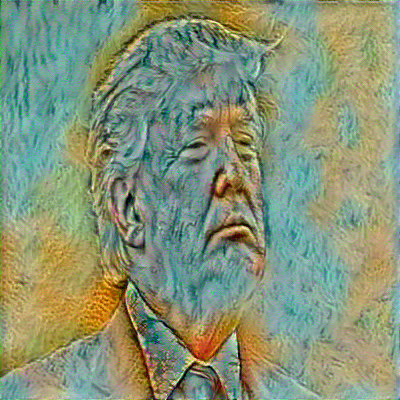

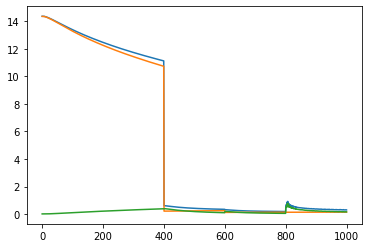

In [165]:
plt.plot(losses)
predict()

In [98]:
l = int(outputs.__len__()/2)
step = 2
pics = [ outputs[i*step] for i in range(0,l, step)]
pics_l = len(pics)

In [90]:
fig, axes = plt.subplots(pics_l, 1, figsize=(5, pics_l*6) )

for i,x in enumerate(pics):
#     axes[i].imshow(x)

SyntaxError: unexpected EOF while parsing (<ipython-input-90-722b2aad1f9b>, line 4)

In [166]:
imageio.mimsave(path/'styled/vincent-3.gif', outputs)

In [ ]:
pred = model()

In [ ]:
pred